### preprocess feature, padding -1 if missing

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from os.path import join
col_idx = [4, 5, 6, 8, 9, 10, 11, -2, -1]
feature_dict = {0: 'id', 5: 'width', 6: 'height', 7: 'imp_position', 9: 'os', 10: 'device_type',
                11: 'app_type', 12: 'imp_type', -2: 'impreq_time', -1: 'price'}
os_type = set(['ios', -1])
imp_type = set(range(5) + [-1])
app_type = set(range(4) + [-1])
device_type = set(range(8) + [-1])
imp_position = set(range(8) + [-1])
def feature_prep(feature):
    feature['price'] = float(feature['price'])
    if len(feature['os']) == 0:
        feature['os'] = -1
    
    if feature['imp_type'] == '4':
        feature['width'] = feature['height'] = -1
    for k in ['id', 'width', 'height', 'imp_position', 'device_type', 'app_type', 'imp_type']:
        try:
            feature[k] = int(feature[k])
        except ValueError, e:
            feature[k] = -1
#     if feature['os'] not in os_type:
#         raise Exception('os %s not in known type set.' % feature['os'])
#     if feature['imp_type'] not in imp_type:
#         raise Exception('imp_type %s not in known type set.' % feature['imp_type'])
#     if feature['app_type'] not in app_type:
#         raise Exception('app_type %s not in known type set.' % feature['app_type'])
#     if feature['device_type'] not in device_type:
#         raise Exception('device_type %s not in known type set.' % feature['device_type'])
#     if feature['imp_position'] not in imp_position:
#         raise Exception('imp_position %s not in known type set.' % feature['imp_position'])
        
# 18736412, train win
# 16453802, train bid
# 10093507, test win
# cols = [idfa,exchange,app_id,web_host,width,height,imp_position,deal_id,os,device_type,app_type,imp_type,imp_is_instl,carrier,country,categories,impreq_time,win_price]
dir_path = './sdml_final_1'
input_list  = ['final_train_bid_data.csv', 'final_train_win_data.csv', 'final_test_win_feature.csv']
lines_count = [16453802, 18736412, 10093507]
# head line
head = ''
for k, v in feature_dict.items():
    head += v
    head += ','
head = head[:-1] + '\n'

for file_path, total_count in zip(input_list, lines_count):
    with tqdm(total=total_count) as pbar:
        with open(join(dir_path, file_path), 'r') as f:
            with open(join(dir_path, 'prep_'+file_path), 'w') as g:
                g.write(head)
                f.readline()
                while True:
                    l = f.readline().strip()
                    if len(l) == 0:
                        break
                    if 'test' in file_path:
                        l += ',-1'
                        buf = l.split(',')
                    else:
                        l = '-1,' + l
                        buf = l.split(',')
                    
                    feature = {v: buf[k] for k, v in feature_dict.items()} 
                    if len(feature['price']) == 0:
                        pbar.update(1)
                        continue
                    try:
                        feature_prep(feature)
                        s = ''
                        for k, v in feature_dict.items():
                            s += str(feature[v])
                            s += ','
                        g.write(s[:-1] + '\n')
                    except :
                        print i, buf
                        print feature
                        raise
                    pbar.update(1)



100%|█████████▉| 10093506/10093507 [02:12<00:00, 76073.49it/s]


### Just a little statistics

In [5]:
import pandas as pd
from prettytable import PrettyTable

dir_path = './sdml_final_1'
input_list  = ['prep_final_test_win_feature.csv', 'prep_final_train_bid_data.csv', 'prep_final_train_win_data.csv']
csvs = [pd.read_csv(join(dir_path, input_file)) for input_file in input_list]
    
for key in csvs[0].keys():
    print 'key : %s' % str(key)
    x = PrettyTable()
    x.field_names = ["value"] + input_list
    if key not in ['id', 'width', 'height', 'impreq_time', 'price']:
        value_set = set.union(*[set(csv[key]) for csv in csvs])
    else:
        value_set = set([-1,])
    for v in value_set:
        cs = ['%d (%.3f)' % (sum(csv[key].isin([v])),sum(csv[key].isin([v])) / float(len(csv))) for csv in csvs]
        row = [str(v),]
        row.extend(cs)
        x.add_row(row)
    print x
        

# s = set(csv['os'])
# for v in s:
#     print sum(csv['os'].isin([v]))

key : id
+-------+---------------------------------+-------------------------------+-------------------------------+
| value | prep_final_test_win_feature.csv | prep_final_train_bid_data.csv | prep_final_train_win_data.csv |
+-------+---------------------------------+-------------------------------+-------------------------------+
|   -1  |            0 (0.000)            |        16453801 (1.000)       |        18585975 (1.000)       |
+-------+---------------------------------+-------------------------------+-------------------------------+
key : width
+-------+---------------------------------+-------------------------------+-------------------------------+
| value | prep_final_test_win_feature.csv | prep_final_train_bid_data.csv | prep_final_train_win_data.csv |
+-------+---------------------------------+-------------------------------+-------------------------------+
|   -1  |         6282553 (0.622)         |        9022551 (0.548)        |        11125518 (0.599)       |
+------

### Enconding to one-hot, saving as numpy array.

In [ ]:
import pandas as pd
import time
import numpy as np
from prettytable import PrettyTable
import pickle


def time_prep(t):
    t = time.gmtime(t)
#     [0, 6], [0, 23], [0,59]
    return t.tm_wday, t.tm_hour, t.tm_min

def one_hot_encoding(column, value_set):
    value2idx = {v:i for i, v in enumerate(value_set)}
    N = len(column)
    ret = np.zeros([N, 1], dtype=np.int32)
    for i,v in enumerate(column):
        ret[i, 0] = value2idx[v]
    return ret
        
    

keys = ['id', 'width', 'height', 'imp_position', 'device_type', 'app_type', 'imp_type', 'impreq_time', 'price']
key_categorical_set = {
    'imp_position': [0, 1, 2, 3, 4, 5, 6, 7, 9, -1],
    'device_type': [1, 2, 4, 5, -1],
    'app_type': [1, 2, -1],
    'imp_type': [1, 4, -1],
            }

dir_path = './sdml_final_1'
input_list  = ['prep_final_test_win_feature.csv', 'prep_final_train_bid_data.csv', 'prep_final_train_win_data.csv']

for input_file in input_list:
    buf = {}
    csv = pd.read_csv(join(dir_path, input_file))
    print 'start process csv %s' % input_file
    for key in keys:
        col = csv[key]
        if key in ['id', 'price','width', 'height']:
            buf['price'] = buf[key] = np.array(col, np.float32).reshape([-1, 1])
        elif key in ['impreq_time',]:
            arr = np.asarray([time_prep(t) for t in col], np.int8)
            buf['weekdays'] = one_hot_encoding(arr[:,0], range(0,7))
            buf['hours'] = one_hot_encoding(arr[:,1], range(0,24))
            buf['mins'] = one_hot_encoding(arr[:,2], range(0,60))
        else:
            buf[key] = one_hot_encoding(col, key_categorical_set[key])
    output_name = join(dir_path, input_file.replace('csv', 'pickle'))
    with open(output_name, 'wb') as out_file:
        pickle.dump(buf, out_file)
    print 'save to %s done.' % output_name
            
            
    
    

start process csv prep_final_test_win_feature.csv
save to ./sdml_final_1/prep_final_test_win_feature.pickle done.
start process csv prep_final_train_bid_data.csv
save to ./sdml_final_1/prep_final_train_bid_data.pickle done.


## show data

In [1]:
import pickle
import numpy as np
from os.path import join
dir_path = './sdml_final_1'
input_list  = ['prep_final_test_win_feature.pickle',
               'prep_final_train_bid_data.pickle',
               'prep_final_train_win_data.pickle']
with open(join(dir_path, 'prep_final_train_win_data.pickle'), 'rb') as f:
    win_dic = pickle.load(f)
with open(join(dir_path, 'prep_final_train_bid_data.pickle'), 'rb') as f:
    bid_dic = pickle.load(f)
    

    


0.8227766904883924


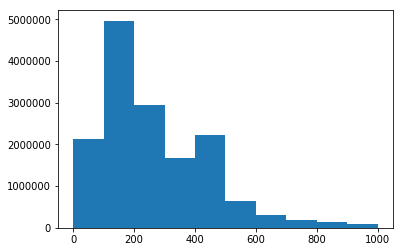

In [45]:
%matplotlib inline  
from tqdm import tqdm

import matplotlib.pyplot as plt
import scipy.stats
def round_5(x):
    return (x//5) * 5
def th(arr, h):
    x = arr < h
    return np.sum(x) / float(len(x))
p = win_dic['price']
arr = (p//5) * 5
print(th(arr, 1000))
plt.hist(arr, range=(0, 1000))
# plt.plot(a)
plt.show()


0.7671006231326123


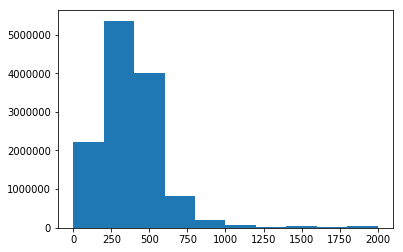

In [46]:
%matplotlib inline  
from tqdm import tqdm

import matplotlib.pyplot as plt
p = bid_dic['price']
arr = (p//5) * 5
print(th(arr, 1000))
plt.hist(arr, range=(0, 2000))
# plt.plot(a)
plt.show()



In [56]:
def trim_max(dic):
    price = dic['price']
    valid_idx = []
    for idx in range(price.shape[0]):
        app = dic['app_type'][idx, 0]
        device = dic['device_type'][idx, 0]
        imp = dic['imp_type'][idx, 0]
        imp_posi = dic['imp_position'][idx, 0]
        weekdays = dic['weekdays'][idx, 0]
        hours = dic['hours'][idx, 0]
        width = dic['width'][idx, 0]
        height = dic['height'][idx, 0]
        if app != 2 and device != 4 and imp != 2 and imp_posi != 9:
            valid_idx.append(idx)
            
    ret = {k: v[valid_idx, :] for k, v in dic.items()}
    return ret

trim_win_dic = trim_max(win_dic)
# bid_dic = trim_max(bid_dic)
print 'trimming done', len(trim_win_dic['price'])/ float(len(win_dic['price']))
trim_bid_dic = trim_max(bid_dic)
# bid_dic = trim_max(bid_dic)
print 'trimming done', len(trim_bid_dic['price'])/ float(len(bid_dic['price']))

trimming done 0.655977477641
trimming done 0.656044460487
